# CovidXrayNet Model

## COVIDx Dataset

In [1]:
from fastai.vision.all import *
import os.path
path = Path('/home/jupyter/covidx')

In [2]:
torch.cuda.empty_cache()

In [3]:
# fix result 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)

In [4]:
df = pd.read_csv(path/'covidx.csv')
df

,patientid,path,finding,source,is_valid
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg,pneumonia,cohen,False
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg,pneumonia,cohen,False
2,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg,pneumonia,cohen,False
3,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg,pneumonia,cohen,False
4,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day5.jpeg,pneumonia,cohen,False
...,...,...,...,...,...
15491,2c917d3a-95cb-4c11-802c-f83e28cb37bc,2c917d3a-95cb-4c11-802c-f83e28cb37bc.png,pneumonia,rsna,True
15492,3040d9d7-d895-453f-887c-616c10531960,3040d9d7-d895-453f-887c-616c10531960.png,pneumonia,rsna,True
15493,c07f52df-d481-434f-84c1-04263926ac40,c07f52df-d481-434f-84c1-04263926ac40.png,pneumonia,rsna,True
15494,c109061a-d815-4cae-8343-9230d8024adf,c109061a-d815-4cae-8343-9230d8024adf.png,pneumonia,rsna,True


In [5]:
df['finding'].value_counts()

normal       8851
pneumonia    6056
COVID-19      589
Name: finding, dtype: int64

In [6]:
df['is_valid'].value_counts()

False    13917
True      1579
Name: is_valid, dtype: int64

## Data Block

In [7]:
get_x=lambda x:path/"images"/f"{x[1]}"
get_y=lambda x:x[2]
splitter=ColSplitter('is_valid')

In [8]:
metrics=[accuracy,  
        #RocAuc(average='macro', multi_class='ovr'),
         MatthewsCorrCoef(sample_weight=None),
         Precision(average='macro'),
         Recall(average='macro'),     
         F1Score(average='macro')] 

#### Data Augmentation Pipeline 

In [9]:
item_tfms=Resize(480, method='squish', pad_mode='zeros', resamples=(2, 0))
batch_tfms=[*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
                            max_rotate=20.0, max_zoom=1.2, max_lighting=0.3, max_warp=0.2, 
                            p_affine=0.75, p_lighting=0.75, 
                            xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', 
                            align_corners=True, batch=False, min_scale=1.0),
                            Normalize.from_stats(*imagenet_stats)]

In [10]:
db = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
               get_x=get_x,
               get_y=get_y,
               splitter=splitter, 
               item_tfms = item_tfms,
               batch_tfms=batch_tfms)

In [11]:
db.item_tfms

(#2) [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ,Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'zeros', 'resamples': (2, 0), 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]

In [12]:
db.batch_tfms

(#4) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,Brightness -- {'max_lighting': 0.3, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
decodes: (TensorImage,object) -> decodes
]

In [13]:
db.splitter(df)

((#13917) [0,1,2,3,4,5,6,7,8,9...],
 (#1579) [13917,13918,13919,13920,13921,13922,13923,13924,13925,13926...])

## Data Loader

#### CNN Hyperparameters

In [14]:
from efficientnet_pytorch import EfficientNet 
arch = EfficientNet.from_pretrained("efficientnet-b0")
bs = 32
epoch = 30
loss_func=LabelSmoothingCrossEntropyFlat(axis=-1, eps=0.2, reduction='mean', flatten=True, floatify=False, is_2d=True)

Loaded pretrained weights for efficientnet-b0


In [15]:
dl = db.dataloaders(df, bs=bs) 

In [16]:
dl.after_item

Pipeline: Resize -- {'size': (480, 480), 'method': 'squish', 'pad_mode': 'zeros', 'resamples': (2, 0), 'p': 1.0} -> ToTensor

In [17]:
dl.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'} -> Brightness -- {'max_lighting': 0.3, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

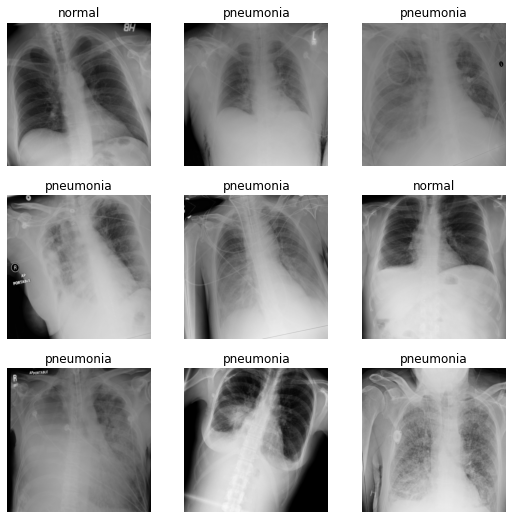

In [18]:
dl.show_batch()

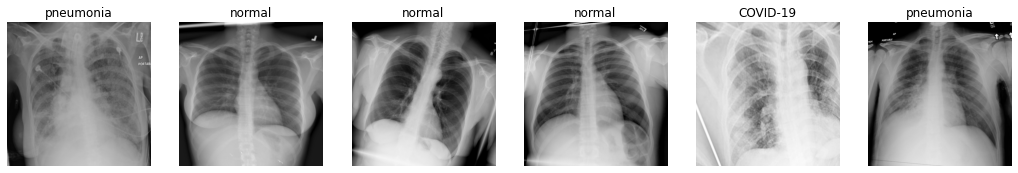

In [19]:
dl.show_batch(max_n=6, nrows=1, ncols=6)

## Training

In [20]:
learn = Learner(dl, model=arch, loss_func=loss_func, metrics=metrics)

In [21]:
learn.summary()

EfficientNet (Input shape: ['32 x 3 x 480 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            32 x 3 x 481 x 481   0          False     
________________________________________________________________
BatchNorm2d          32 x 32 x 240 x 240  64         True      
________________________________________________________________
ZeroPad2d            32 x 32 x 242 x 242  0          False     
________________________________________________________________
BatchNorm2d          32 x 32 x 240 x 240  64         True      
________________________________________________________________
Identity             32 x 32 x 1 x 1      0          False     
________________________________________________________________
Identity             32 x 8 x 1 x 1       0          False     
________________________________________________________________
Identity             32 x 32 x 240 x 240  0          False     
_______________________________________________

In [22]:
learn.fine_tune(30) 

epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,precision_score,recall_score,f1_score,time
0,2.148689,2.494614,0.835339,0.689222,0.897276,0.586119,0.584458,02:38


epoch,train_loss,valid_loss,accuracy,matthews_corrcoef,precision_score,recall_score,f1_score,time
0,2.051933,2.031061,0.933502,0.876100,0.905072,0.874721,0.888783,02:37
1,2.027956,2.028454,0.936035,0.880311,0.946889,0.855531,0.891809,02:37
2,2.005783,2.034451,0.935402,0.879501,0.947497,0.843877,0.881718,02:36
3,2.017411,2.099018,0.917036,0.845750,0.929758,0.750720,0.788753,02:36
4,2.011442,2.042567,0.934136,0.877303,0.947928,0.858100,0.894459,02:36
5,2.020347,2.022962,0.943635,0.895084,0.950141,0.886841,0.913553,02:37
6,2.016466,2.070476,0.930969,0.872774,0.953904,0.845317,0.887423,02:36
7,2.002652,2.022348,0.941735,0.892147,0.920047,0.921934,0.920979,02:36
8,2.015983,2.011866,0.940469,0.891158,0.937367,0.924330,0.929458,02:36
9,1.999658,2.084357,0.924636,0.859465,0.927233,0.809757,0.848580,02:37


In [23]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@log_args(but_as=Learner.fit)
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py
Type:      method


In [24]:
learn.save('covidxraynet')

Path('models/covidxraynet.pth')

## Interpretation

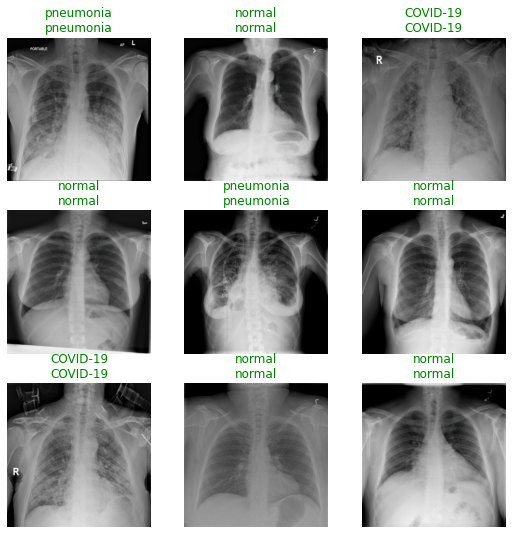

In [25]:
learn.show_results()

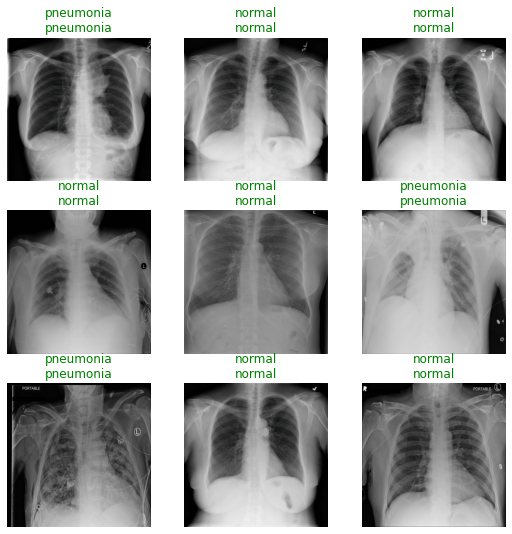

In [26]:
learn.show_results()

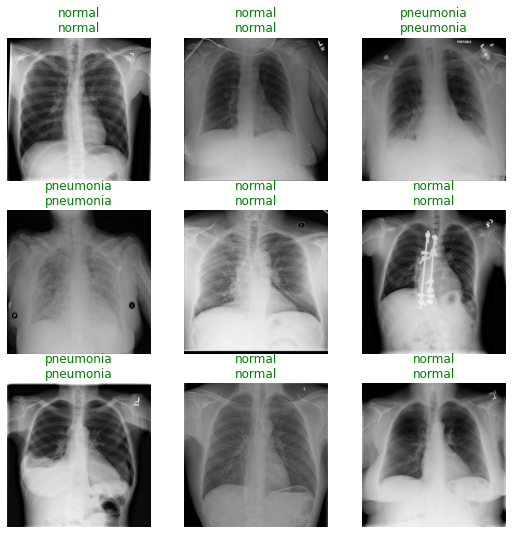

In [27]:
learn.show_results()

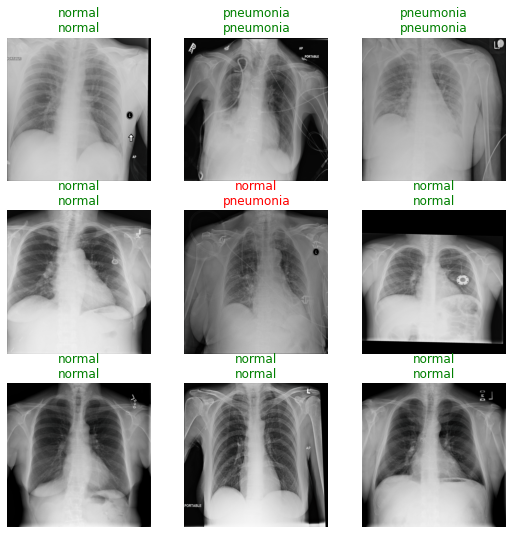

In [28]:
learn.show_results()

In [29]:
interp = Interpretation.from_learner(learn)

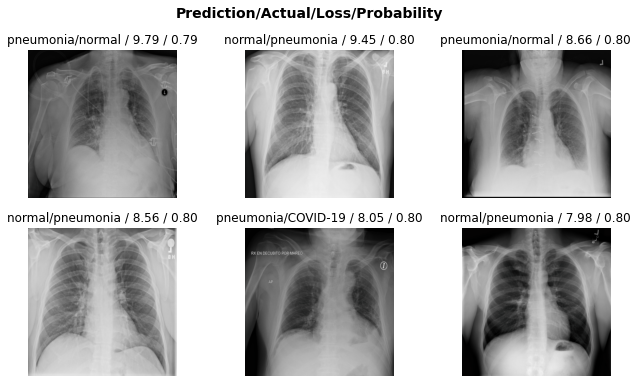

In [30]:
interp.plot_top_losses(6, figsize=(11,6))

In [31]:
interp2 = ClassificationInterpretation.from_learner(learn)

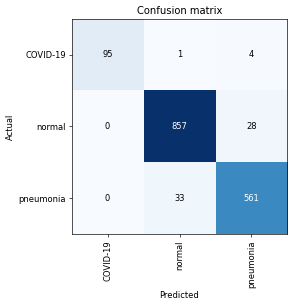

In [32]:
interp2.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [33]:
interp2.confusion_matrix()

array([[ 95,   1,   4],
       [  0, 857,  28],
       [  0,  33, 561]])

In [34]:
interp2.most_confused(min_val=1)

[('pneumonia', 'normal', 33),
 ('normal', 'pneumonia', 28),
 ('COVID-19', 'pneumonia', 4),
 ('COVID-19', 'normal', 1)]

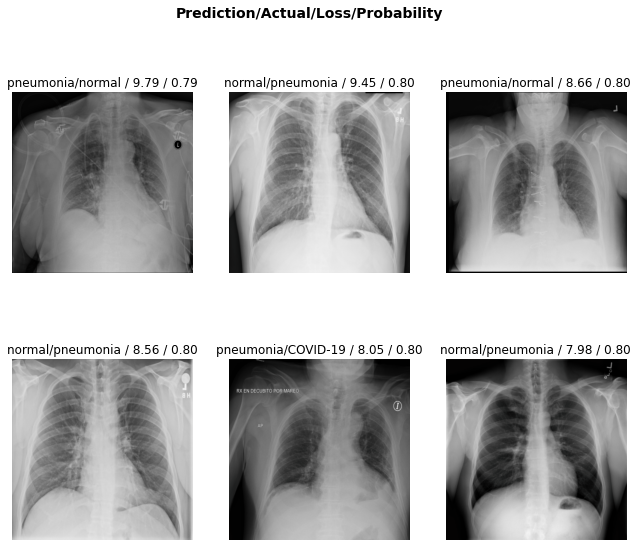

In [35]:
interp.plot_top_losses(6, figsize=(11,9))

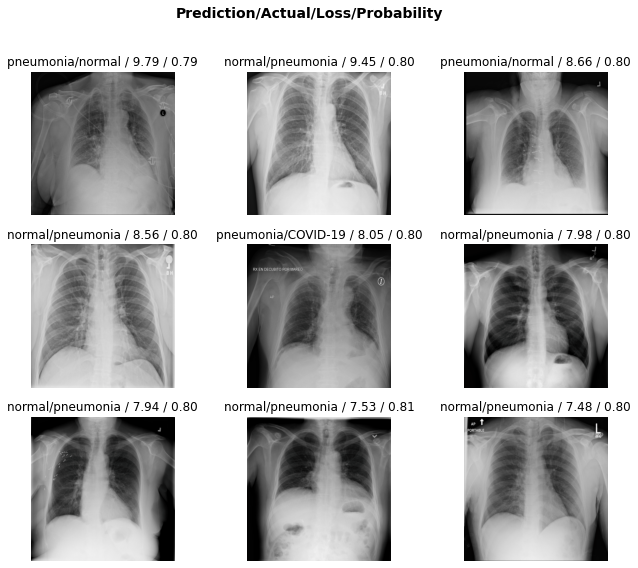

In [36]:
interp.plot_top_losses(9, figsize=(11,9))